In [213]:
#Joseph Cormier
#Professor Leili Shahyriyari

#import some useful libraries
import os
import pandas as pd
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import scipy.stats as sp
from scipy import stats
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import mannwhitneyu
from statannot import add_stat_annotation
import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import math

# READ, NORM, VAR
# ------------------------------------------------------------------------------------

In [2]:
#use read_csv for better performance (source: https://stackoverflow.com/questions/31362573/performance-difference-in-pandas-read-table-vs-read-csv-vs-from-csv-vs-read-e)

#reading the data from the location of the data
notebook_path=os.path.dirname(r'TCGA Lung Adenocarcinoma.ipynb')
#location_of_data=notebook_path
#rna_file_name= r"HiSeqV2_PANCAN.csv"
#rna_file_path= r"C:\Users\Joseph\Downloads\REU\working project\xena\""
rna_file_path_name = r'C:\Users\Joseph\Downloads\REU\working project\xena\HiSeqV2_PANCAN.csv'
survival_file_path_name = r'C:\Users\Joseph\Downloads\REU\working project\xena\clinical\LUAD_survival.csv'
clinical_file_path_name = r'C:\Users\Joseph\Downloads\REU\working project\xena\clinical\LUAD_clinicalMatrix.csv'

In [3]:
#reading data from csv

rna = pd.read_csv(rna_file_path_name)
#to make sure we do not process the name of genes we will convert them to string
rna['sample'] = rna['sample'].astype(str)
#want to switch sample label to patient so clinical data will concat easier
rna = rna.rename(columns={"sample":"patient"})
rna.head()

,patient,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
0,ARHGEF10L,0.125808,0.561708,-0.237592,-1.180492,-0.656192,0.139908,-0.537692,-0.839092,0.677108,...,0.226508,-2.342092,-0.207692,-0.659792,-1.651292,-2.621192,-1.025192,0.070108,0.305608,0.263208
1,HIF3A,-1.294926,6.069174,3.581474,3.927674,-0.525926,-1.497426,-0.021226,0.179974,1.092974,...,2.539674,-1.259526,-0.387226,3.689474,3.509374,1.986874,-1.993426,2.790974,-0.018326,4.657474
2,RNF17,-0.112935,-0.531035,0.592065,0.291065,-0.531035,0.475865,0.071065,-0.531035,-0.531035,...,-0.068235,-0.531035,0.428265,0.202865,0.567665,0.408165,-0.531035,0.440465,-0.531035,0.049365
3,RNF10,-1.411872,-0.228672,-0.108372,-0.043472,-0.156672,-0.605472,0.139328,-0.450172,0.583528,...,-0.451572,0.261228,-0.331772,-0.213372,-0.189472,0.091028,0.492828,0.037428,0.003728,-0.334572
4,RNF11,0.203922,0.052122,-0.499978,0.710822,0.373522,0.129022,0.436522,0.529622,0.314922,...,-0.155778,0.362522,-0.520578,0.031222,-0.966478,0.318322,0.150822,-0.357778,-0.451578,0.156422


In [4]:
#normalization function

def normalizing_patients(df_rna):
    
    """
        input df_rna: rna-seq data frame that includes the column 'patient'
            columns are patients, and rows are genes
        output df_normalized_rna: normalized (scaled) data
        function:  using pandas methods dividing the value of each gene for each patient 
                by the maximum value of that patient.
    """
    
    #drop name of genes
    df_rna_values =  df_rna.drop(['patient'], axis=1) 
    
    #finding maximum level expression of genes for each patient
    Max_each_patient = df_rna_values.max(axis=0)
    
    #Divide the values of each gene by the maximum value of gene expression of the same patient patient
    df_normalized_rna_values = df_rna_values.divide(Max_each_patient, axis=1)
    
    #concat the name of genes to the normalized dataframe
    df_normalized_rna = pd.concat([df_rna['patient'], df_normalized_rna_values], axis=1)
    
    return df_normalized_rna

In [5]:
normalized_rna = normalizing_patients(rna)
normalized_rna =  normalized_rna.set_index(['patient'])
normalized_rna.head()

,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,TCGA-53-A4EZ-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
patient,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,0.010088,0.044537,-0.019065,-0.072812,-0.050064,0.012833,-0.036592,-0.059766,0.046155,0.092983,...,0.017269,-0.242817,-0.015542,-0.054533,-0.103855,-0.189069,-0.071752,0.005567,0.025109,0.024307
HIF3A,-0.103839,0.481212,0.287385,0.242257,-0.040125,-0.137349,-0.001445,0.012819,0.074502,0.220494,...,0.193628,-0.130582,-0.028977,0.304943,0.220715,0.143315,-0.139517,0.221607,-0.001506,0.430117
RNF17,-0.009056,-0.042105,0.047509,0.017953,-0.040515,0.043648,0.004836,-0.037824,-0.036198,-0.047804,...,-0.005202,-0.055055,0.032048,0.016767,0.035702,0.029441,-0.037166,0.034974,-0.043629,0.004559
RNF10,-0.113216,-0.018131,-0.008696,-0.002681,-0.011953,-0.055536,0.009482,-0.032064,0.039776,0.053889,...,-0.034428,0.027083,-0.024827,-0.017636,-0.011916,0.006566,0.034492,0.002972,0.000306,-0.030898
RNF11,0.016352,0.004133,-0.040119,0.043843,0.028498,0.011834,0.029707,0.037723,0.021467,-0.059511,...,-0.011877,0.037585,-0.038956,0.002581,-0.060785,0.022961,0.010556,-0.028408,-0.037101,0.014446


In [6]:
#secondary normalization function

def normalizing_patients_sl(df_rna):
    
    """
        input df_rna: rna-seq data frame that includes the column 'patient'
            columns are patients, and rows are genes
        output df_normalized_rna: normalized (scaled) data
        function:  using Scikit-learn methods dividing the value of each gene for each patient 
                by the maximum value of that patient.
                
        Note that in Scikit learn features are assumed to be in columns and here we want to normalized 
        the values of columns not the features which are the genes.
    """
    
    from sklearn.preprocessing import MaxAbsScaler
    
    
    #drop name of genes
    df_rna_values =  df_rna.drop(['patient'], axis=1) 
    
    #This estimator scales each feature by its maximum absolute value.
    #The output of fit_tansform is an ndarray
    array_normalized_rna_values = MaxAbsScaler().fit_transform(df_rna_values)
    
    #df_rna_values.columns.values.tolist() give us the name of columns
    #convernting ndarray to dataframe
    df_normalized_rna_values = pd.DataFrame(array_normalized_rna_values,  columns= df_rna_values.columns.values.tolist())
    
    #concat the name of genes to the normalized dataframe
    df_normalized_rna = pd.concat([df_rna['patient'], df_normalized_rna_values], axis=1)
    df_normalized_rna=df_normalized_rna.set_index(['patient'])
    return df_normalized_rna

In [7]:
normalized_rna_by_scikit = normalizing_patients_sl(rna)

normalized_rna_by_scikit.head()

,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,TCGA-53-A4EZ-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
patient,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,0.010088,0.044537,-0.019065,-0.072812,-0.050064,0.012833,-0.036592,-0.059766,0.046155,0.092983,...,0.017269,-0.242817,-0.015542,-0.054533,-0.103855,-0.189069,-0.071752,0.005567,0.025109,0.024307
HIF3A,-0.103839,0.481212,0.287385,0.242257,-0.040125,-0.137349,-0.001445,0.012819,0.074502,0.220494,...,0.193628,-0.130582,-0.028977,0.304943,0.220715,0.143315,-0.139517,0.221607,-0.001506,0.430117
RNF17,-0.009056,-0.042105,0.047509,0.017953,-0.040515,0.043648,0.004836,-0.037824,-0.036198,-0.047804,...,-0.005202,-0.055055,0.032048,0.016767,0.035702,0.029441,-0.037166,0.034974,-0.043629,0.004559
RNF10,-0.113216,-0.018131,-0.008696,-0.002681,-0.011953,-0.055536,0.009482,-0.032064,0.039776,0.053889,...,-0.034428,0.027083,-0.024827,-0.017636,-0.011916,0.006566,0.034492,0.002972,0.000306,-0.030898
RNF11,0.016352,0.004133,-0.040119,0.043843,0.028498,0.011834,0.029707,0.037723,0.021467,-0.059511,...,-0.011877,0.037585,-0.038956,0.002581,-0.060785,0.022961,0.010556,-0.028408,-0.037101,0.014446


In [8]:
#correction heck function for normalized functions

def checking(df, normalized_df):
    """
        input df: the   pandas data frame
        input normalized_df: the normalized dataframe 
        output : a message 
        function: checking if the normalization method has been correctly implemented.
    """
    
    from pandas.testing import assert_frame_equal
    
    normalized_rna_by_scikit = normalizing_patients_sl(df)
    try:
        assert_frame_equal(normalized_rna_by_scikit,normalized_df)
        return "it is correct"
    except:
        return "There is an error"

In [9]:
checking(rna, normalized_rna)

'it is correct'

In [10]:
#find the variance of each genes 
var_genes=normalized_rna.var(axis=1)
#add a new coloum in the data frame
normalized_rna['Variance'] = var_genes.values

normalized_rna.head()

,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,TCGA-53-A4EZ-01,...,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01,Variance
patient,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,0.010088,0.044537,-0.019065,-0.072812,-0.050064,0.012833,-0.036592,-0.059766,0.046155,0.092983,...,-0.242817,-0.015542,-0.054533,-0.103855,-0.189069,-0.071752,0.005567,0.025109,0.024307,0.003306
HIF3A,-0.103839,0.481212,0.287385,0.242257,-0.040125,-0.137349,-0.001445,0.012819,0.074502,0.220494,...,-0.130582,-0.028977,0.304943,0.220715,0.143315,-0.139517,0.221607,-0.001506,0.430117,0.027817
RNF17,-0.009056,-0.042105,0.047509,0.017953,-0.040515,0.043648,0.004836,-0.037824,-0.036198,-0.047804,...,-0.055055,0.032048,0.016767,0.035702,0.029441,-0.037166,0.034974,-0.043629,0.004559,0.004997
RNF10,-0.113216,-0.018131,-0.008696,-0.002681,-0.011953,-0.055536,0.009482,-0.032064,0.039776,0.053889,...,0.027083,-0.024827,-0.017636,-0.011916,0.006566,0.034492,0.002972,0.000306,-0.030898,0.000697
RNF11,0.016352,0.004133,-0.040119,0.043843,0.028498,0.011834,0.029707,0.037723,0.021467,-0.059511,...,0.037585,-0.038956,0.002581,-0.060785,0.022961,0.010556,-0.028408,-0.037101,0.014446,0.001314


In [11]:
normalized_rna.shape

(20530, 577)

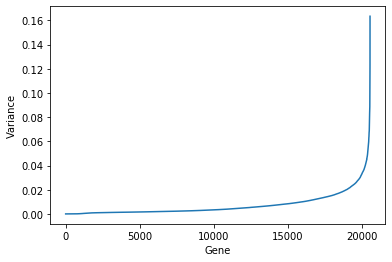

In [12]:
#plot the variance

plt.plot(sorted(var_genes))
plt.xlabel('Gene')
plt.ylabel('Variance')
plt.savefig('sorted_variance.eps', format='eps',bbox_inches='tight', dpi=1000)

# TOP10VAR
# ------------------------------------------------------------------------------------

In [13]:
#sorted the variance and finding the top 10 variance
sorted_var_genes=sorted(var_genes)
sorted_var_genes[-10:]

[0.1002654207067927,
 0.10344626201929076,
 0.10866486476464425,
 0.11726813662597635,
 0.11881424493188472,
 0.11884352966783267,
 0.12295099956006596,
 0.12328044362054667,
 0.16048293679433462,
 0.1634594178675486]

In [14]:
# Finding genes that has top 10 high variance
top_10_var_rna = normalized_rna[normalized_rna['Variance']>=0.1002654207067927]
#drop variance column
top_10_var_rna=top_10_var_rna.drop(columns=['Variance'])
# top 10 genes with the highest variance
top_10_var_rna

,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,TCGA-53-A4EZ-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
patient,,,,,,,,,,,,,,,,,,,,,
XIST,-0.322611,-0.286097,0.259693,0.306804,0.214484,0.520012,0.315587,0.340511,0.401630,-0.348563,...,-0.348090,0.637775,-0.526382,-0.276127,-0.276102,-0.507380,-0.197259,-0.135049,-0.355367,0.503072
AKR1B10,0.221460,0.021791,-0.367033,-0.254395,-0.327370,-0.331705,0.384620,0.003272,0.086074,0.898210,...,-0.071290,0.237565,-0.274909,0.603256,0.167901,-0.356801,-0.346203,-0.392764,0.228513,-0.031857
SCGB1A1,0.579628,0.685824,0.002383,0.486090,0.679633,0.518264,0.577375,0.596424,0.123514,-0.118269,...,0.818685,0.376693,0.896112,0.483853,0.020465,0.053413,-0.056306,0.170840,0.337067,0.226284
XAGE1D,0.841570,0.768225,0.792710,0.039867,0.870977,0.577780,0.668219,0.754061,0.778328,-0.090357,...,-0.023607,0.991038,0.716983,-0.091524,0.742674,0.721380,0.594866,0.747069,0.762099,0.926412
FGB,0.262937,0.695638,-0.202485,-0.030693,-0.142497,-0.139100,-0.046245,-0.037339,0.036098,0.425705,...,-0.192389,-0.261617,0.529124,0.345748,-0.158705,0.542770,-0.055594,0.530034,0.132702,-0.019617
DDX3Y,0.330690,0.471563,-0.383855,-0.318033,-0.343365,-0.472945,-0.309928,-0.367260,-0.162389,0.164854,...,0.387220,-0.534571,0.355760,0.277578,0.284426,0.394635,0.359307,0.471834,0.356727,-0.354846
RPS4Y1,0.314323,0.441347,-0.464057,-0.328974,-0.469648,-0.472265,-0.396310,-0.353542,-0.169826,0.663604,...,0.420058,-0.638194,0.407223,0.215928,0.116245,0.462893,0.389325,0.511464,0.461538,-0.301116
PLUNC,0.509859,0.948603,0.057055,-0.084690,0.313574,0.815836,0.351777,0.709785,0.207837,-0.123604,...,0.529993,0.412839,0.764836,0.621638,0.357655,0.749732,1.000000,0.821999,0.253810,0.249486
SFTPC,0.484936,0.815779,0.300726,1.000000,0.755907,0.631618,0.902842,0.899076,0.316149,-0.023196,...,0.719780,0.090885,0.927289,0.623414,0.641245,0.728237,0.347299,0.006338,0.840114,0.965501


In [15]:
#transpose indexs
rna_top10 = top_10_var_rna.T
patient_id_rna = rna_top10.index

In [81]:
#truncate patient id
dic_patient_id = {id_:id_[:-3] for id_ in patient_id_rna}
rna_top10 = rna_top10.rename(dic_patient_id, axis='index')
rna_top10.head()

patient,XIST,AKR1B10,SCGB1A1,XAGE1D,FGB,DDX3Y,RPS4Y1,PLUNC,SFTPC,KDM5D
TCGA-69-7978,-0.322611,0.221460,0.579628,0.841570,0.262937,0.330690,0.314323,0.509859,0.484936,0.345821
TCGA-62-8399,-0.286097,0.021791,0.685824,0.768225,0.695638,0.471563,0.441347,0.948603,0.815779,0.495120
TCGA-78-7539,0.259693,-0.367033,0.002383,0.792710,-0.202485,-0.383855,-0.464057,0.057055,0.300726,-0.388124
TCGA-50-5931,0.306804,-0.254395,0.486090,0.039867,-0.030693,-0.318033,-0.328974,-0.084690,1.000000,-0.298338
TCGA-73-4658,0.214484,-0.327370,0.679633,0.870977,-0.142497,-0.343365,-0.469648,0.313574,0.755907,-0.369030


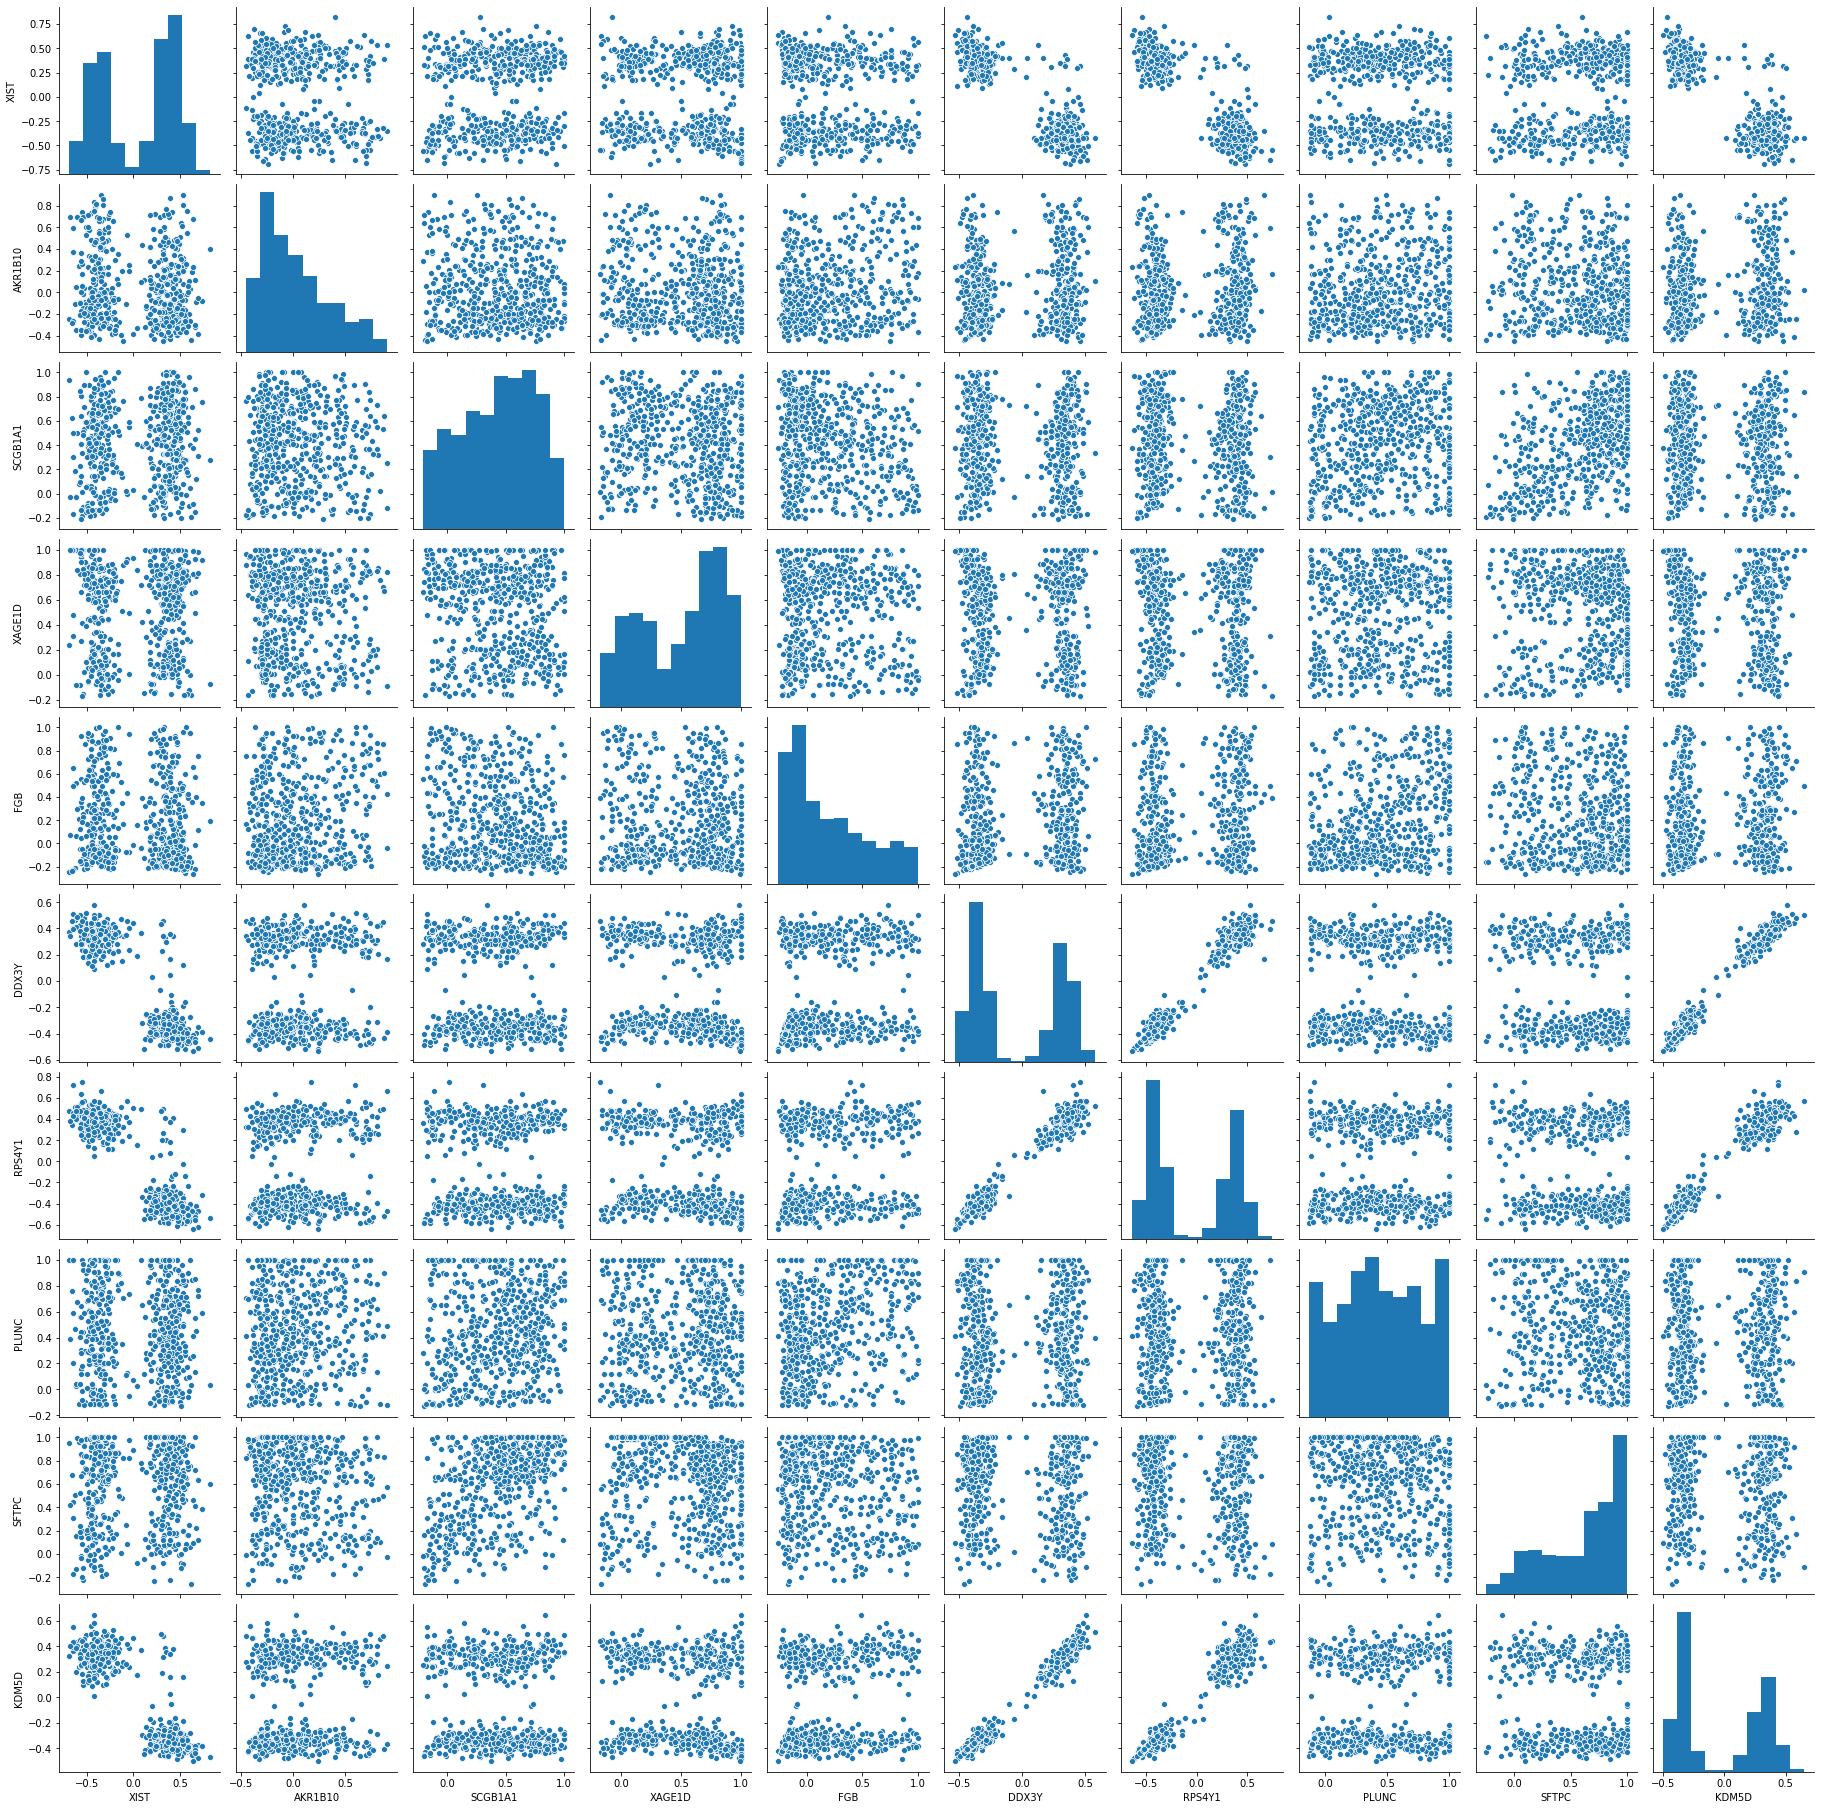

In [17]:
#correlation analysis of top 10 genes
sns.pairplot(rna_top10)

# CLINICAL
# ------------------------------------------------------------------------------------

In [76]:
#reading clinical data, renaming index, and truncating patient ID
clinical_data = pd.read_csv(clinical_file_path_name)
clinical_data = clinical_data.rename(columns={"sampleID":"patient"})
clinical_data = clinical_data.set_index(['patient'])

#truncate
patient_id = clinical_data.index
dic_patient_id = {id_:id_[:-3] for id_ in patient_id}
clinical_data = clinical_data.rename(dic_patient_id, axis='index')

clinical_data.head()

,ABSOLUTE_Ploidy,ABSOLUTE_Purity,AKT1,ALK_translocation,BRAF,CBL,CTNNB1,Canonical_mut_in_KRAS_EGFR_ALK,Cnncl_mt_n_KRAS_EGFR_ALK_RET_ROS1_BRAF_ERBB2_HRAS_NRAS_AKT1_MAP2,EGFR,...,_GENOMIC_ID_TCGA_LUAD_exp_HiSeqV2_exon,_GENOMIC_ID_TCGA_LUAD_miRNA_HiSeq,_GENOMIC_ID_TCGA_LUAD_RPPA_RBN,_GENOMIC_ID_TCGA_LUAD_exp_HiSeqV2_PANCAN,_GENOMIC_ID_TCGA_LUAD_PDMRNAseq,_GENOMIC_ID_TCGA_LUAD_RPPA,_GENOMIC_ID_TCGA_LUAD_exp_HiSeqV2_percentile,_GENOMIC_ID_TCGA_LUAD_mutation_broad_gene,_GENOMIC_ID_data/public/TCGA/LUAD/miRNA_HiSeq_gene,_GENOMIC_ID_TCGA_LUAD_miRNA_GA
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,e6a101b9-61f9-4ed1-a59f-d9db3fdb4555,NaN,TCGA-05-4244-01A-21-2190-20,e6a101b9-61f9-4ed1-a59f-d9db3fdb4555,TCGA-05-4244-01,59881fe3-70f4-4fa0-9355-f50250872752,e6a101b9-61f9-4ed1-a59f-d9db3fdb4555,TCGA-05-4244-01A-01D-1105-08,NaN,TCGA-05-4244-01
TCGA-05-4249,3.77,0.46,none,NaN,p.A762E,none,none,Y,Y,none,...,d1a8d88d-1708-4959-9695-6f2e67853bd5,NaN,TCGA-05-4249-01A-21-2190-20,d1a8d88d-1708-4959-9695-6f2e67853bd5,TCGA-05-4249-01,5b46a235-49a6-43ea-91b6-82a384702477,d1a8d88d-1708-4959-9695-6f2e67853bd5,TCGA-05-4249-01A-01D-1105-08,NaN,TCGA-05-4249-01
TCGA-05-4250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,bba9333a-09f7-4585-b22e-e4ae4049f7da,NaN,TCGA-05-4250-01A-21-2190-20,bba9333a-09f7-4585-b22e-e4ae4049f7da,TCGA-05-4250-01,3f069d62-c371-4f30-bdb4-c58093bbb1d7,bba9333a-09f7-4585-b22e-e4ae4049f7da,TCGA-05-4250-01A-01D-1105-08,NaN,TCGA-05-4250-01
TCGA-05-4382,NaN,NaN,none,NaN,p.L613F,none,none,N,N,"p.R222L, p.E545Q",...,e4177b01-6898-4bb7-b38d-0c09f85c5668,NaN,NaN,e4177b01-6898-4bb7-b38d-0c09f85c5668,TCGA-05-4382-01,NaN,e4177b01-6898-4bb7-b38d-0c09f85c5668,TCGA-05-4382-01A-01D-1931-08,NaN,TCGA-05-4382-01
TCGA-05-4384,2.04,0.48,none,NaN,none,none,p.F777S,N,N,none,...,7d6cf896-b04a-431a-a192-aaf540eeaf77,TCGA-05-4384-01,TCGA-05-4384-01A-21-2190-20,7d6cf896-b04a-431a-a192-aaf540eeaf77,TCGA-05-4384-01,5e735c28-5f2b-47ec-98fb-2f57cc8a5d6a,7d6cf896-b04a-431a-a192-aaf540eeaf77,TCGA-05-4384-01A-01D-1753-08,TCGA-05-4384-01,NaN


In [78]:
#reading survival data, renaming index
survival_data = pd.read_csv(survival_file_path_name)
survival_data = survival_data.drop(columns='sample')
survival_data = survival_data.rename(columns={"_PATIENT":"patient"})
survival_data = survival_data.set_index(['patient'])

survival_data.head()

,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
patient,,,,,,,,,
TCGA-05-4244,0,0.0,0.0,0.0,NaN,NaN,0,0.0,NaN
TCGA-05-4249,0,1523.0,0.0,1523.0,NaN,NaN,0,1523.0,NaN
TCGA-05-4250,1,121.0,NaN,121.0,NaN,NaN,0,121.0,NaN
TCGA-05-4382,0,607.0,0.0,607.0,1.0,334.0,1,334.0,NaN
TCGA-05-4384,0,426.0,0.0,426.0,NaN,NaN,1,183.0,NaN


## CLINICAL: top10Var truncate

In [20]:
#concat clinical data to rna and survival data

patients_clinical = clinical_data.index.array
patients_survival = survival_data.index.array
patients_rna = rna_top10.index.array

In [21]:
#truncating data to make all dfs the same shape

patients_in_clinical_not_in_rna = [patient for patient in patients_clinical if patient not in patients_rna]
clinical_data_trunc = clinical_data.drop(index = patients_in_clinical_not_in_rna)
clinical_data_trunc = clinical_data_trunc[~clinical_data_trunc.index.duplicated(keep='first')]
clinical_data_trunc.shape

(516, 147)

In [22]:
#truncating data to make all dfs the same shape

patients_in_survival_not_in_rna = [patient for patient in patients_survival if patient not in patients_rna]
survival_data_trunc = survival_data.drop(index = patients_in_survival_not_in_rna)
survival_data_trunc = survival_data_trunc[~survival_data_trunc.index.duplicated(keep='first')]
survival_data_trunc.shape

(516, 9)

In [79]:
rna_top10.shape

(576, 10)

In [74]:
#truncating data to make all dfs the same shape

rna_top10_new= rna_top10[~rna_top10.index.duplicated(keep='first')]
rna_top10_new.shape

(516, 10)

In [24]:
#test

clinical_survival_rna = pd.concat([clinical_data_trunc, survival_data_trunc], axis=1, sort=False)
clinical_survival_rna.head()

,ABSOLUTE_Ploidy,ABSOLUTE_Purity,AKT1,ALK_translocation,BRAF,CBL,CTNNB1,Canonical_mut_in_KRAS_EGFR_ALK,Cnncl_mt_n_KRAS_EGFR_ALK_RET_ROS1_BRAF_ERBB2_HRAS_NRAS_AKT1_MAP2,EGFR,...,_GENOMIC_ID_TCGA_LUAD_miRNA_GA,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TCGA-05-4244-01,0,0.0,0.0,0.0,NaN,NaN,0,0.0,NaN
TCGA-05-4249,3.77,0.46,none,NaN,p.A762E,none,none,Y,Y,none,...,TCGA-05-4249-01,0,1523.0,0.0,1523.0,NaN,NaN,0,1523.0,NaN
TCGA-05-4250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,TCGA-05-4250-01,1,121.0,NaN,121.0,NaN,NaN,0,121.0,NaN
TCGA-05-4382,NaN,NaN,none,NaN,p.L613F,none,none,N,N,"p.R222L, p.E545Q",...,TCGA-05-4382-01,0,607.0,0.0,607.0,1.0,334.0,1,334.0,NaN
TCGA-05-4384,2.04,0.48,none,NaN,none,none,p.F777S,N,N,none,...,NaN,0,426.0,0.0,426.0,NaN,NaN,1,183.0,NaN


# CORRELATIONS
# ------------------------------------------------------------------------------------

## CORRELATIONS: top10Var

In [82]:
#most correlated variables in clincial survival rna dataframe

corr_matrix2 = clinical_survival_rna.corr().abs()
posCorr_matrix2 = corr_matrix2[corr_matrix2 >=.4]
upper = posCorr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), 1).astype(np.bool))
upperCorr = upper.unstack().sort_values(kind='quicksort').drop_duplicates().dropna()
upperCorr.head(60)

OS                                                                karnofsky_performance_score                                         0.403316
DSS                                                               karnofsky_performance_score                                         0.406686
OS                                                                days_to_collection                                                  0.408515
PFI.time                                                          year_of_initial_pathologic_diagnosis                                0.410227
OS                                                                year_of_initial_pathologic_diagnosis                                0.413106
shortest_dimension                                                Estimated_allele_fraction_of_a_clonal_varnt_prsnt_t_1_cpy_pr_cll    0.418562
longest_dimension                                                 days_to_additional_surgery_locoregional_procedure                   0.426698

In [83]:
#continuation of most correlated
corr_matrix2 = clinical_survival_rna.corr().abs()
posCorr_matrix2 = corr_matrix2[corr_matrix2 >=0.890641]
upper = posCorr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), 1).astype(np.bool))
upperCorr = upper.unstack().sort_values(ascending=True, kind='quicksort').drop_duplicates().dropna()
upperCorr

DFI.time                                                          days_to_new_tumor_event_after_initial_treatment                     0.891938
DSS.time                                                          days_to_new_tumor_event_after_initial_treatment                     0.893612
PFI.time                                                          OS.time                                                             0.894059
                                                                  days_to_last_followup                                               0.897657
pre_bronchodilator_fev1_percent                                   post_bronchodilator_fev1_percent                                    0.898418
Estimated_allele_fraction_of_a_clonal_varnt_prsnt_t_1_cpy_pr_cll  ABSOLUTE_Purity                                                     0.898488
days_to_new_tumor_event_after_initial_treatment                   days_to_death                                                       0.903032

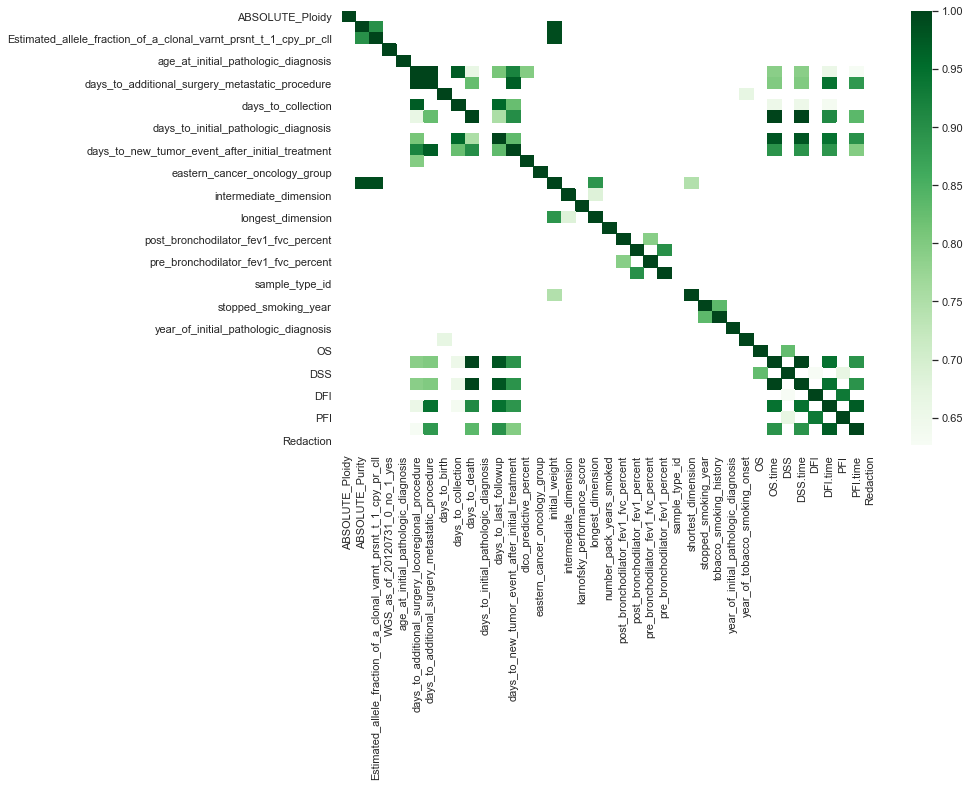

In [84]:
#heatmap of postive correlations

corr = clinical_survival_rna.corr()

posCorr = corr[corr>=.6]
plt.figure(figsize=(12,8))
sns.heatmap(posCorr, cmap="Greens")


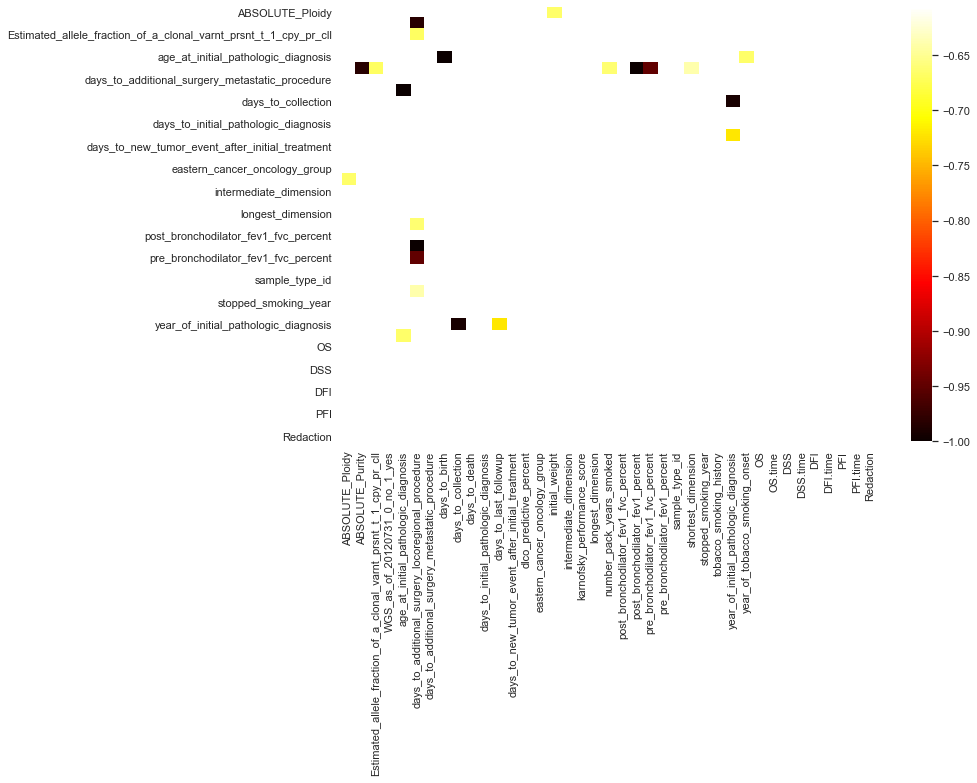

In [85]:
#heatmap of negative correlations

negCorr = corr[corr<=-.6]
plt.figure(figsize=(12,8))
sns.heatmap(negCorr, cmap='hot')

# P-VALUE
# ------------------------------------------------------------------------------------

In [25]:
#needed for later
clinical_survival_rna['Smoker'] = ""

In [123]:
#clinical dataframes that are needed

patients_clinical2 = clinical_data.index.array
patients_survival2 = survival_data.index.array

In [124]:
#test size reduction without duplicates (duplicates bc of name trunc)

mylist = list( dict.fromkeys(patients_clinical2) )
mylist2 = list( dict.fromkeys(patients_survival2) )
print( len(mylist), len(mylist2) )

584 519


In [104]:
#need to create same index by truncating clinical

patients_in_clinical_not_in_survival = [patient for patient in patients_clinical2 if patient not in patients_survival2]
clinical_data_trunc2 = clinical_data.drop(index = patients_in_clinical_not_in_survival)
clinical_data_trunc2 = clinical_data_trunc2[~clinical_data_trunc2.index.duplicated(keep='first')]
clinical_data_trunc2.shape

(519, 147)

In [127]:
#remove duplicates of survival

survival_data_trunc2 = survival_data[~survival_data.index.duplicated(keep='first')]
survival_data_trunc2.shape

(519, 9)

In [134]:
#creating smoke test df from clinical + survival

dfSmokeTest = pd.concat([clinical_data_trunc2, survival_data_trunc2], axis=1, sort=False)
dfSmokeTest.shape

(519, 156)

## non smokers

In [141]:
#creating data for non-Smokers under number_pack_years_smoked for SMOKETEST df

for i, row in dfSmokeTest.iterrows():
    if dfSmokeTest.at[i,'tobacco_smoking_history_indicator'] == 'Lifelong Non-smoker':
        packSmoked_val = 0
        dfSmokeTest.at[i, 'Smoker'] = "no" #needed for boxplot
        dfSmokeTest.at[i,'number_pack_years_smoked'] = packSmoked_val


In [142]:
#creating data for non-Smokers under number_pack_years_smoked for CLIN_SUR_RNA df
#same thing as above but for different df

for i, row in clinical_survival_rna.iterrows():
    if clinical_survival_rna.at[i,'tobacco_smoking_history_indicator'] == 'Lifelong Non-smoker':
        packSmoked_val = 0
        clinical_survival_rna.at[i,'number_pack_years_smoked'] = packSmoked_val


In [143]:
#needed for boxplot
for i, row in dfSmokeTest.iterrows():
    if dfSmokeTest.at[i, 'tobacco_smoking_history_indicator'] ==\
    'Current reformed smoker for > 15 years' or\
    dfSmokeTest.at[i, 'tobacco_smoking_history_indicator'] ==\
    'Current reformed smoker for < or = 15 years' or\
    dfSmokeTest.at[i, 'tobacco_smoking_history_indicator'] ==\
    'Current smoker':
        dfSmokeTest.at[i, 'Smoker'] = "yes" #needed for boxplot
    

In [144]:
#test for smoker column
dfSmokeTest.head()

,ABSOLUTE_Ploidy,ABSOLUTE_Purity,AKT1,ALK_translocation,BRAF,CBL,CTNNB1,Canonical_mut_in_KRAS_EGFR_ALK,Cnncl_mt_n_KRAS_EGFR_ALK_RET_ROS1_BRAF_ERBB2_HRAS_NRAS_AKT1_MAP2,EGFR,...,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,Smoker
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-05-4244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,0.0,0.0,NaN,NaN,0,0.0,NaN,NaN
TCGA-05-4249,3.77,0.46,none,NaN,p.A762E,none,none,Y,Y,none,...,0,1523.0,0.0,1523.0,NaN,NaN,0,1523.0,NaN,yes
TCGA-05-4250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,121.0,NaN,121.0,NaN,NaN,0,121.0,NaN,NaN
TCGA-05-4382,NaN,NaN,none,NaN,p.L613F,none,none,N,N,"p.R222L, p.E545Q",...,0,607.0,0.0,607.0,1.0,334.0,1,334.0,NaN,yes
TCGA-05-4384,2.04,0.48,none,NaN,none,none,p.F777S,N,N,none,...,0,426.0,0.0,426.0,NaN,NaN,1,183.0,NaN,yes


In [145]:
#test
dfSmokeTest['Smoker'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [146]:
#test
dfSmokeTest['tobacco_smoking_history_indicator'].size

519

In [147]:
#create non smoke df

dfNoSmoke = dfSmokeTest[dfSmokeTest['tobacco_smoking_history_indicator'] == 'Lifelong Non-smoker']

dfNoSmoke.shape

(31, 157)

In [150]:
#creating list of patients to make subset of gene expression DF
#varifying length from above

index = dfNoSmoke.index
noSmoke_list = list(index)
len(noSmoke_list)

31

In [153]:
#taking earlier normalized RNA Transposing it, then subsetting it with nonSmoker population

noSmokeCopy = normalized_rna.copy()
noSmokeCopyT = noSmokeCopy.T

#truncate patient id
patientID = noSmokeCopyT.index
dicID = {id_:id_[:-3] for id_ in patientID}
noSmokeCopyT = noSmokeCopyT.rename(dicID, axis='index')

noSmokeCopyFixdID = noSmokeCopyT.T

noSmokeCopyFixdID.shape

(20530, 577)

In [160]:
#creating final non smoker df
finalNoSmoke = noSmokeCopyFixdID[noSmoke_list]

#remove duplicates
finalNoSmoke = finalNoSmoke.T[~finalNoSmoke.T.index.duplicated(keep='first')]
finalNoSmoke = finalNoSmoke.T
finalNoSmoke.shape

(20530, 31)

In [161]:
#find the variance of each genes 
finalNoSmokeVar = finalNoSmoke.copy()

NSvar_genes=finalNoSmoke.var(axis=1)
#add a new coloum in the data frame
finalNoSmokeVar['Variance'] = NSvar_genes.values

finalNoSmokeVar.head()

,TCGA-05-4395,TCGA-05-4402,TCGA-05-5429,TCGA-05-5715,TCGA-35-3615,TCGA-38-4628,TCGA-38-6178,TCGA-44-2661,TCGA-44-2665,TCGA-44-3919,...,TCGA-75-5147,TCGA-75-6203,TCGA-75-6205,TCGA-75-6212,TCGA-75-7030,TCGA-78-7143,TCGA-78-7540,TCGA-86-6562,TCGA-86-7713,Variance
patient,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,-0.068706,0.017110,-0.098088,0.013179,-0.074262,-0.074942,0.022368,-0.019857,-0.018970,-0.025242,...,-0.007044,0.005958,0.023235,-0.001766,-0.024526,0.010089,0.018512,0.015381,-0.126122,0.001797
HIF3A,-0.302366,0.121066,-0.045076,-0.028221,0.023937,0.122590,0.268047,0.016719,0.184452,0.041776,...,0.229601,0.229601,-0.173337,0.042936,0.160541,0.133949,0.063145,0.267206,0.402423,0.024666
RNF17,-0.050972,0.003140,-0.033971,0.302707,0.058009,-0.045137,-0.048580,0.068945,-0.031840,-0.039149,...,0.161818,0.014463,-0.044398,0.082414,0.038061,0.002738,-0.033992,0.007652,0.108873,0.016826
RNF10,0.028242,0.043805,-0.027237,0.012734,-0.051278,-0.040966,-0.010198,-0.039747,0.007305,-0.017846,...,-0.016224,-0.014805,0.001348,0.014485,-0.005332,-0.028597,0.020472,-0.015690,0.017055,0.000490
RNF11,0.034144,0.069477,0.029377,0.003229,0.019608,0.066164,-0.021103,0.016138,0.022408,0.016154,...,0.026257,-0.001219,0.013814,0.008877,0.015623,0.001643,-0.016187,-0.037502,-0.016950,0.001267


Text(0, 0.5, 'Variance')

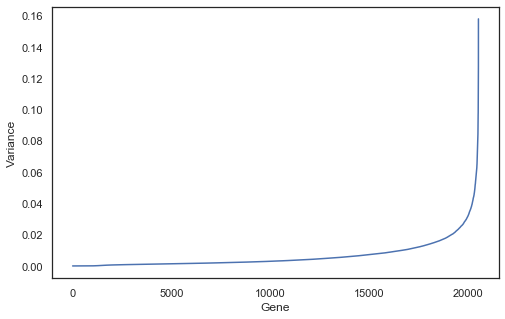

In [162]:
#plot the variance

plt.plot(sorted(finalNoSmokeVar['Variance']))
plt.xlabel('Gene')
plt.ylabel('Variance')
#plt.savefig('sorted_variance.eps', format='eps',bbox_inches='tight', dpi=1000)

In [163]:
#sorted the variance and finding the top 10 variance
sorted_NSvar_genes=sorted(NSvar_genes)
sorted_NSvar_genes[-10:]

[0.10420517979393833,
 0.10458680664785454,
 0.10830018784563968,
 0.10909738993952393,
 0.10968748674175328,
 0.11078187550200543,
 0.11663618928294336,
 0.12351047332558553,
 0.12735104499023897,
 0.15793838815958589]

In [40]:
#can view most variant NonSmoker genes if wanted

## smokers

In [164]:
#creating smoking df

dfSmoke = dfSmokeTest[dfSmokeTest['tobacco_smoking_history_indicator'] == \
                                'Current reformed smoker for > 15 years']

dfS1 =  dfSmokeTest[dfSmokeTest['tobacco_smoking_history_indicator'] == \
                                'Current reformed smoker for < or = 15 years']

dfS2 = dfSmokeTest[dfSmokeTest['tobacco_smoking_history_indicator'] == 'Current smoker']
                                
dfSmoke.append(dfS1)
dfSmoke.append(dfS2)

dfSmoke.shape

(67, 157)

In [166]:
#creating list of patients to make subset of gene expression DF
#varifying length from above

index2 = dfSmoke.index
Smoke_list = list(index2)
len(Smoke_list)

67

In [43]:
#taking earlier normalized RNA Transposing it, then subsetting it with nonSmoker population

smokeCopy = normalized_rna.copy()
smokeCopyT = smokeCopy.T

#truncate patient id
patientID = smokeCopyT.index
dicID = {id_:id_[:-3] for id_ in patientID}
smokeCopyT = smokeCopyT.rename(dicID, axis='index')

smokeCopyT = smokeCopyT.T

smokeCopyT.shape

(20530, 577)

In [168]:
#creating final smoker df

finalSmoke = smokeCopyT[Smoke_list]

#remove duplicates
finalSmoke = finalSmoke.T[~finalSmoke.T.index.duplicated(keep='first')]
finalSmoke = finalSmoke.T
finalSmoke.head()

,TCGA-05-4249,TCGA-05-4384,TCGA-05-4389,TCGA-05-4396,TCGA-05-4403,TCGA-05-4425,TCGA-05-4426,TCGA-05-4433,TCGA-05-5423,TCGA-05-5428,...,TCGA-91-6849,TCGA-93-7347,TCGA-95-7043,TCGA-95-7567,TCGA-97-7546,TCGA-97-7552,TCGA-97-7554,TCGA-97-7937,TCGA-97-7938,TCGA-97-7941
patient,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,-0.044428,-0.020739,0.013230,-0.000889,-0.021251,-0.065367,0.016232,-0.023022,-0.022844,-0.063840,...,-0.057871,0.007844,-0.219975,-0.000413,-0.057173,-0.033437,-0.106480,-0.151948,-0.070273,0.013352
HIF3A,-0.024809,0.155785,0.264279,0.237990,-0.024728,0.039419,-0.089266,0.092968,-0.024723,-0.109843,...,0.337695,0.004419,-0.230825,-0.168128,0.037081,0.032730,0.099722,0.087097,0.111075,0.139686
RNF17,-0.041413,0.010266,-0.009573,-0.033731,-0.036322,-0.036655,-0.035824,0.023949,0.017117,-0.041083,...,-0.033812,-0.036064,0.023057,-0.012357,0.034373,-0.039477,-0.040043,-0.047896,-0.037921,-0.040262
RNF10,0.018516,0.015238,-0.009213,0.046415,-0.003151,-0.024026,-0.017282,-0.026932,-0.015143,-0.076688,...,-0.007862,0.016620,-0.035596,0.032356,0.003080,-0.001403,-0.030115,-0.001224,0.018726,-0.009930
RNF11,0.000922,0.003588,0.012506,-0.040708,0.020343,0.002652,0.047150,-0.049849,0.012133,0.046667,...,0.036422,-0.007503,-0.053278,-0.027223,0.044320,0.009733,-0.002607,0.028178,0.028772,-0.025913


In [169]:
#find the variance of each genes 
finalSmokeVar = finalSmoke.copy()
Svar_genes=finalSmoke.var(axis=1)

#add a new coloum in the data frame
finalSmokeVar['Variance'] = Svar_genes.values

finalSmokeVar.head()

,TCGA-05-4249,TCGA-05-4384,TCGA-05-4389,TCGA-05-4396,TCGA-05-4403,TCGA-05-4425,TCGA-05-4426,TCGA-05-4433,TCGA-05-5423,TCGA-05-5428,...,TCGA-93-7347,TCGA-95-7043,TCGA-95-7567,TCGA-97-7546,TCGA-97-7552,TCGA-97-7554,TCGA-97-7937,TCGA-97-7938,TCGA-97-7941,Variance
patient,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,-0.044428,-0.020739,0.013230,-0.000889,-0.021251,-0.065367,0.016232,-0.023022,-0.022844,-0.063840,...,0.007844,-0.219975,-0.000413,-0.057173,-0.033437,-0.106480,-0.151948,-0.070273,0.013352,0.003351
HIF3A,-0.024809,0.155785,0.264279,0.237990,-0.024728,0.039419,-0.089266,0.092968,-0.024723,-0.109843,...,0.004419,-0.230825,-0.168128,0.037081,0.032730,0.099722,0.087097,0.111075,0.139686,0.029519
RNF17,-0.041413,0.010266,-0.009573,-0.033731,-0.036322,-0.036655,-0.035824,0.023949,0.017117,-0.041083,...,-0.036064,0.023057,-0.012357,0.034373,-0.039477,-0.040043,-0.047896,-0.037921,-0.040262,0.001488
RNF10,0.018516,0.015238,-0.009213,0.046415,-0.003151,-0.024026,-0.017282,-0.026932,-0.015143,-0.076688,...,0.016620,-0.035596,0.032356,0.003080,-0.001403,-0.030115,-0.001224,0.018726,-0.009930,0.000787
RNF11,0.000922,0.003588,0.012506,-0.040708,0.020343,0.002652,0.047150,-0.049849,0.012133,0.046667,...,-0.007503,-0.053278,-0.027223,0.044320,0.009733,-0.002607,0.028178,0.028772,-0.025913,0.000976


Text(0, 0.5, 'Variance')

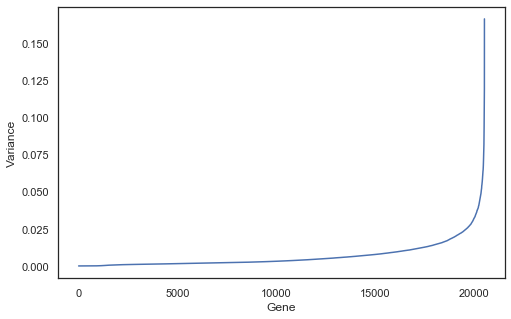

In [170]:
#plot the variance

plt.plot(sorted(finalSmokeVar['Variance']))
plt.xlabel('Gene')
plt.ylabel('Variance')
#plt.savefig('sorted_variance.eps', format='eps',bbox_inches='tight', dpi=1000)

In [171]:
#sorted the variance and finding the top 10 variance
sorted_Svar_genes=sorted(Svar_genes)
sorted_Svar_genes[-10:]

[0.10380525045054789,
 0.104522402878897,
 0.10921750868706745,
 0.11071258532298298,
 0.1126956233707156,
 0.11357497201367393,
 0.1147398183802461,
 0.11963048527519489,
 0.15305434348903998,
 0.16654351723822827]

In [48]:
#can view most variant NonSmoker genes if wanted

# p-value results smoke vs nonSmoke

In [215]:
#test to see if comparing pval from different dataframes will work

pval = mannwhitneyu(finalNoSmoke.iloc[0], finalSmoke.iloc[0])
p = pval.pvalue
print(p)

0.07547379933243781


In [173]:
#evaluating smker vs nonsmker dataframe to find genes with most significant
#variance

smallP=[]
indx = []


for i in range(len(finalNoSmoke)):
    if set(finalNoSmoke.iloc[i]) != set(finalSmoke.iloc[i]): 
        pval = mannwhitneyu(finalNoSmoke.iloc[i], finalSmoke.iloc[i])
        p = pval.pvalue
        if (p <= 1.00e-04):
            smallP.append(p)
            indx.append(i)
            
indx

[3010]

In [176]:
#sorting pvalue by size

# sortedSmallP = smallP.copy()
# sortedIndx = indx.copy()
# leastSignificant = sortedIndx[1]
# sortedIndx.remove(leastSignificant)
# sortedIndx.insert(leastSignificant, 5052)
# sortedSmallP.sort(reverse=True)


In [177]:
#test
#sortedIndx

In [178]:
#test
#sortedSmallP

In [175]:
#test
print(finalNoSmoke.index.values[3010], finalSmoke.index.values[3010])

NGB NGB


In [179]:
#label list instead of index based

geneNamesbySmallestPval = []
for i in sortedIndx:
    geneNamesbySmallestPval.append(finalNoSmoke.index.values[i])
    
geneNamesbySmallestPval

['NGB']

In [180]:
#need to add smallestPval Genes to the clinical_survival_rna dataframe

normalized_Copy = normalized_rna.copy()

normCopyT = normalized_Copy.T
patient_ID_Copy = normCopyT.index

#truncate patient id
dic_patient_id_Copy = {id_:id_[:-3] for id_ in patient_ID_Copy}
normCopyT = normCopyT.rename(dic_patient_id_Copy, axis='index')
normCopyT.head()


patient,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-69-7978,0.010088,-0.103839,-0.009056,-0.113216,0.016352,0.007970,-0.017809,0.040444,-0.033952,0.232149,...,0.090992,-0.067769,0.141146,-0.102753,0.018012,0.069252,0.064325,0.008677,0.047742,-0.017859
TCGA-62-8399,0.044537,0.481212,-0.042105,-0.018131,0.004133,-0.095622,-0.026870,0.114956,0.003124,0.021775,...,-0.022683,-0.004402,-0.002239,0.003807,0.023408,0.025143,0.085557,-0.062058,0.246923,-0.030836
TCGA-78-7539,-0.019065,0.287385,0.047509,-0.008696,-0.040119,-0.002039,0.013080,0.010564,-0.004084,-0.142091,...,0.177329,-0.127354,0.125608,0.211736,0.003942,-0.099748,-0.102969,0.002737,0.045856,0.018744
TCGA-50-5931,-0.072812,0.242257,0.017953,-0.002681,0.043843,0.064818,-0.034812,0.103866,0.024592,-0.120551,...,-0.046190,0.055541,0.117411,-0.079036,-0.033879,0.172870,0.138808,-0.033356,0.245853,0.022882
TCGA-73-4658,-0.050064,-0.040125,-0.040515,-0.011953,0.028498,0.034126,-0.033493,0.139738,-0.032303,0.160854,...,-0.057135,-0.071062,0.146117,-0.013473,0.003229,0.084742,0.115508,-0.034645,0.220733,0.014785


In [185]:
#making small df to work with

smallP_df = normCopyT[['NGB']].copy()

smallP_df.tail()

patient,NGB
TCGA-91-6831,-0.100573
TCGA-MN-A4N4,-0.069150
TCGA-55-8302,-0.118062
TCGA-MP-A4TK,-0.079106
Varia,0.014372


In [193]:
patients_smallP = smallP_df.index.array
patients_dfSmokeTest = dfSmokeTest.index.array
patients_smallP.shape

(577,)

In [195]:
#need to create same index by truncating smallP_df

patients_in_smallP_not_in_smokeTest = [patient for patient in patients_smallP if patient not in patients_dfSmokeTest]
smallP_df_trunc = smallP_df.drop(index = patients_in_smallP_not_in_smokeTest)
smallP_df_trunc = smallP_df_trunc[~smallP_df_trunc.index.duplicated(keep='first')]
smallP_df_trunc.shape

(516, 1)

In [196]:
#may need to truncate dfSmokeTest because smallP_df_trunc may be missing some patients

dfSmokeTest2 = dfSmokeTest.copy()
patients_dfSmokeTest2 = dfSmokeTest2.index.array
patients_SmallP_trunc = smallP_df_trunc.index.array

patients_in_smokeTest_not_in_smallP = [patient for patient in patients_dfSmokeTest2 if patient not in patients_SmallP_trunc]
smokeTest2_data_trunc = dfSmokeTest2.drop(index = patients_in_smokeTest_not_in_smallP)
smokeTest2_data_trunc = smokeTest2_data_trunc[~smokeTest2_data_trunc.index.duplicated(keep='first')]
smokeTest2_data_trunc.shape

(516, 157)

In [200]:
#concat SmallP to SmokeTestdd

smokeTest_SmallP = pd.concat([smokeTest2_data_trunc, smallP_df_trunc], axis=1, sort=False)

smokeTest_SmallP.head()

,ABSOLUTE_Ploidy,ABSOLUTE_Purity,AKT1,ALK_translocation,BRAF,CBL,CTNNB1,Canonical_mut_in_KRAS_EGFR_ALK,Cnncl_mt_n_KRAS_EGFR_ALK_RET_ROS1_BRAF_ERBB2_HRAS_NRAS_AKT1_MAP2,EGFR,...,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,Smoker,NGB
TCGA-05-4244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,0,0.0,NaN,NaN,-0.103462
TCGA-05-4249,3.77,0.46,none,NaN,p.A762E,none,none,Y,Y,none,...,1523.0,0.0,1523.0,NaN,NaN,0,1523.0,NaN,yes,0.040990
TCGA-05-4250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121.0,NaN,121.0,NaN,NaN,0,121.0,NaN,NaN,-0.126082
TCGA-05-4382,NaN,NaN,none,NaN,p.L613F,none,none,N,N,"p.R222L, p.E545Q",...,607.0,0.0,607.0,1.0,334.0,1,334.0,NaN,yes,-0.139646
TCGA-05-4384,2.04,0.48,none,NaN,none,none,p.F777S,N,N,none,...,426.0,0.0,426.0,NaN,NaN,1,183.0,NaN,yes,-0.094045


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

yes v.s. no: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.034e-05 U_stat=1.530e+03


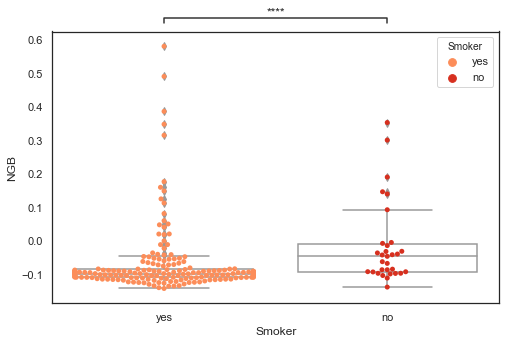

In [229]:
#graph of low and high SFTPC level and overall survival time 
sns.set(rc={'figure.figsize':(8,5)})

sns.set_style("white")

ax=sns.boxplot(x='Smoker', y='NGB', data = smokeTest_SmallP, order = ['yes','no'],color = 'w')
palette={'yes':'#fc8d59','no':'#d7301f'}
sns.swarmplot(x='Smoker', y='NGB', data=smokeTest_SmallP, order=['yes','no'],hue='Smoker',palette=palette)
plt.xticks(rotation=0)

#adding statistical values on the graph
add_stat_annotation(ax, data=smokeTest_SmallP, x='Smoker', y='NGB',order=['yes','no'],
                box_pairs=[('yes','no')], test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

#plt.text(-0.5,16,"B", fontsize=25)
#plt.savefig('SFTPB_level.eps', format='eps',bbox_inches='tight', dpi=1000)

plt.show()